# 3D Digit Classifier
#### _Authors: Chamath, Omer, and Misi_

In [12]:
import os
import numpy as np
import pandas as pd
from skimage.draw import line
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Explore

### 3D plot

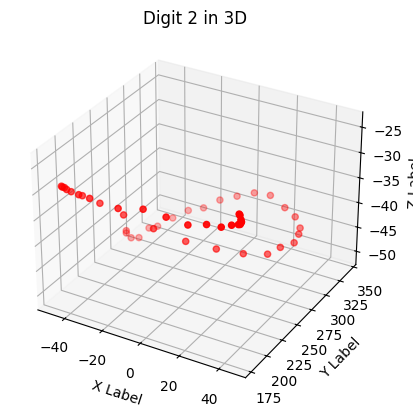

In [2]:
folder_path = 'digits_3d/training_data/'
file_name = 'stroke_2_0006.csv'
to_load = os.path.join(folder_path, file_name)
digit = pd.read_csv(to_load, header=None)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(digit[0], digit[1], digit[2], c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Digit 2 in 3D')
plt.show()

### 2D plot (without z axis)

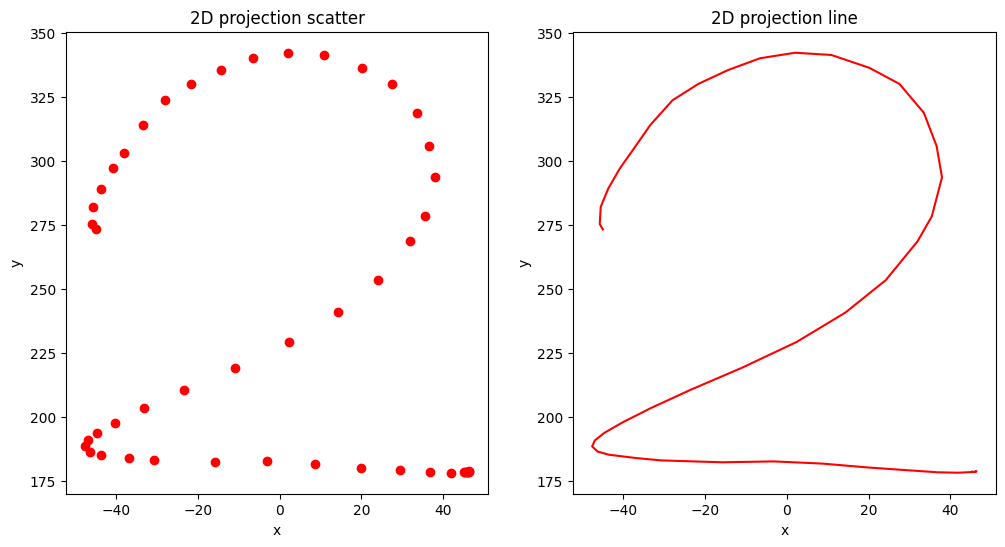

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(digit[0], digit[1], c='r', marker='o')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('2D projection scatter')

ax2.plot(digit[0], digit[1], c='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D projection line')

plt.show()

## Potential Issue with digit 1

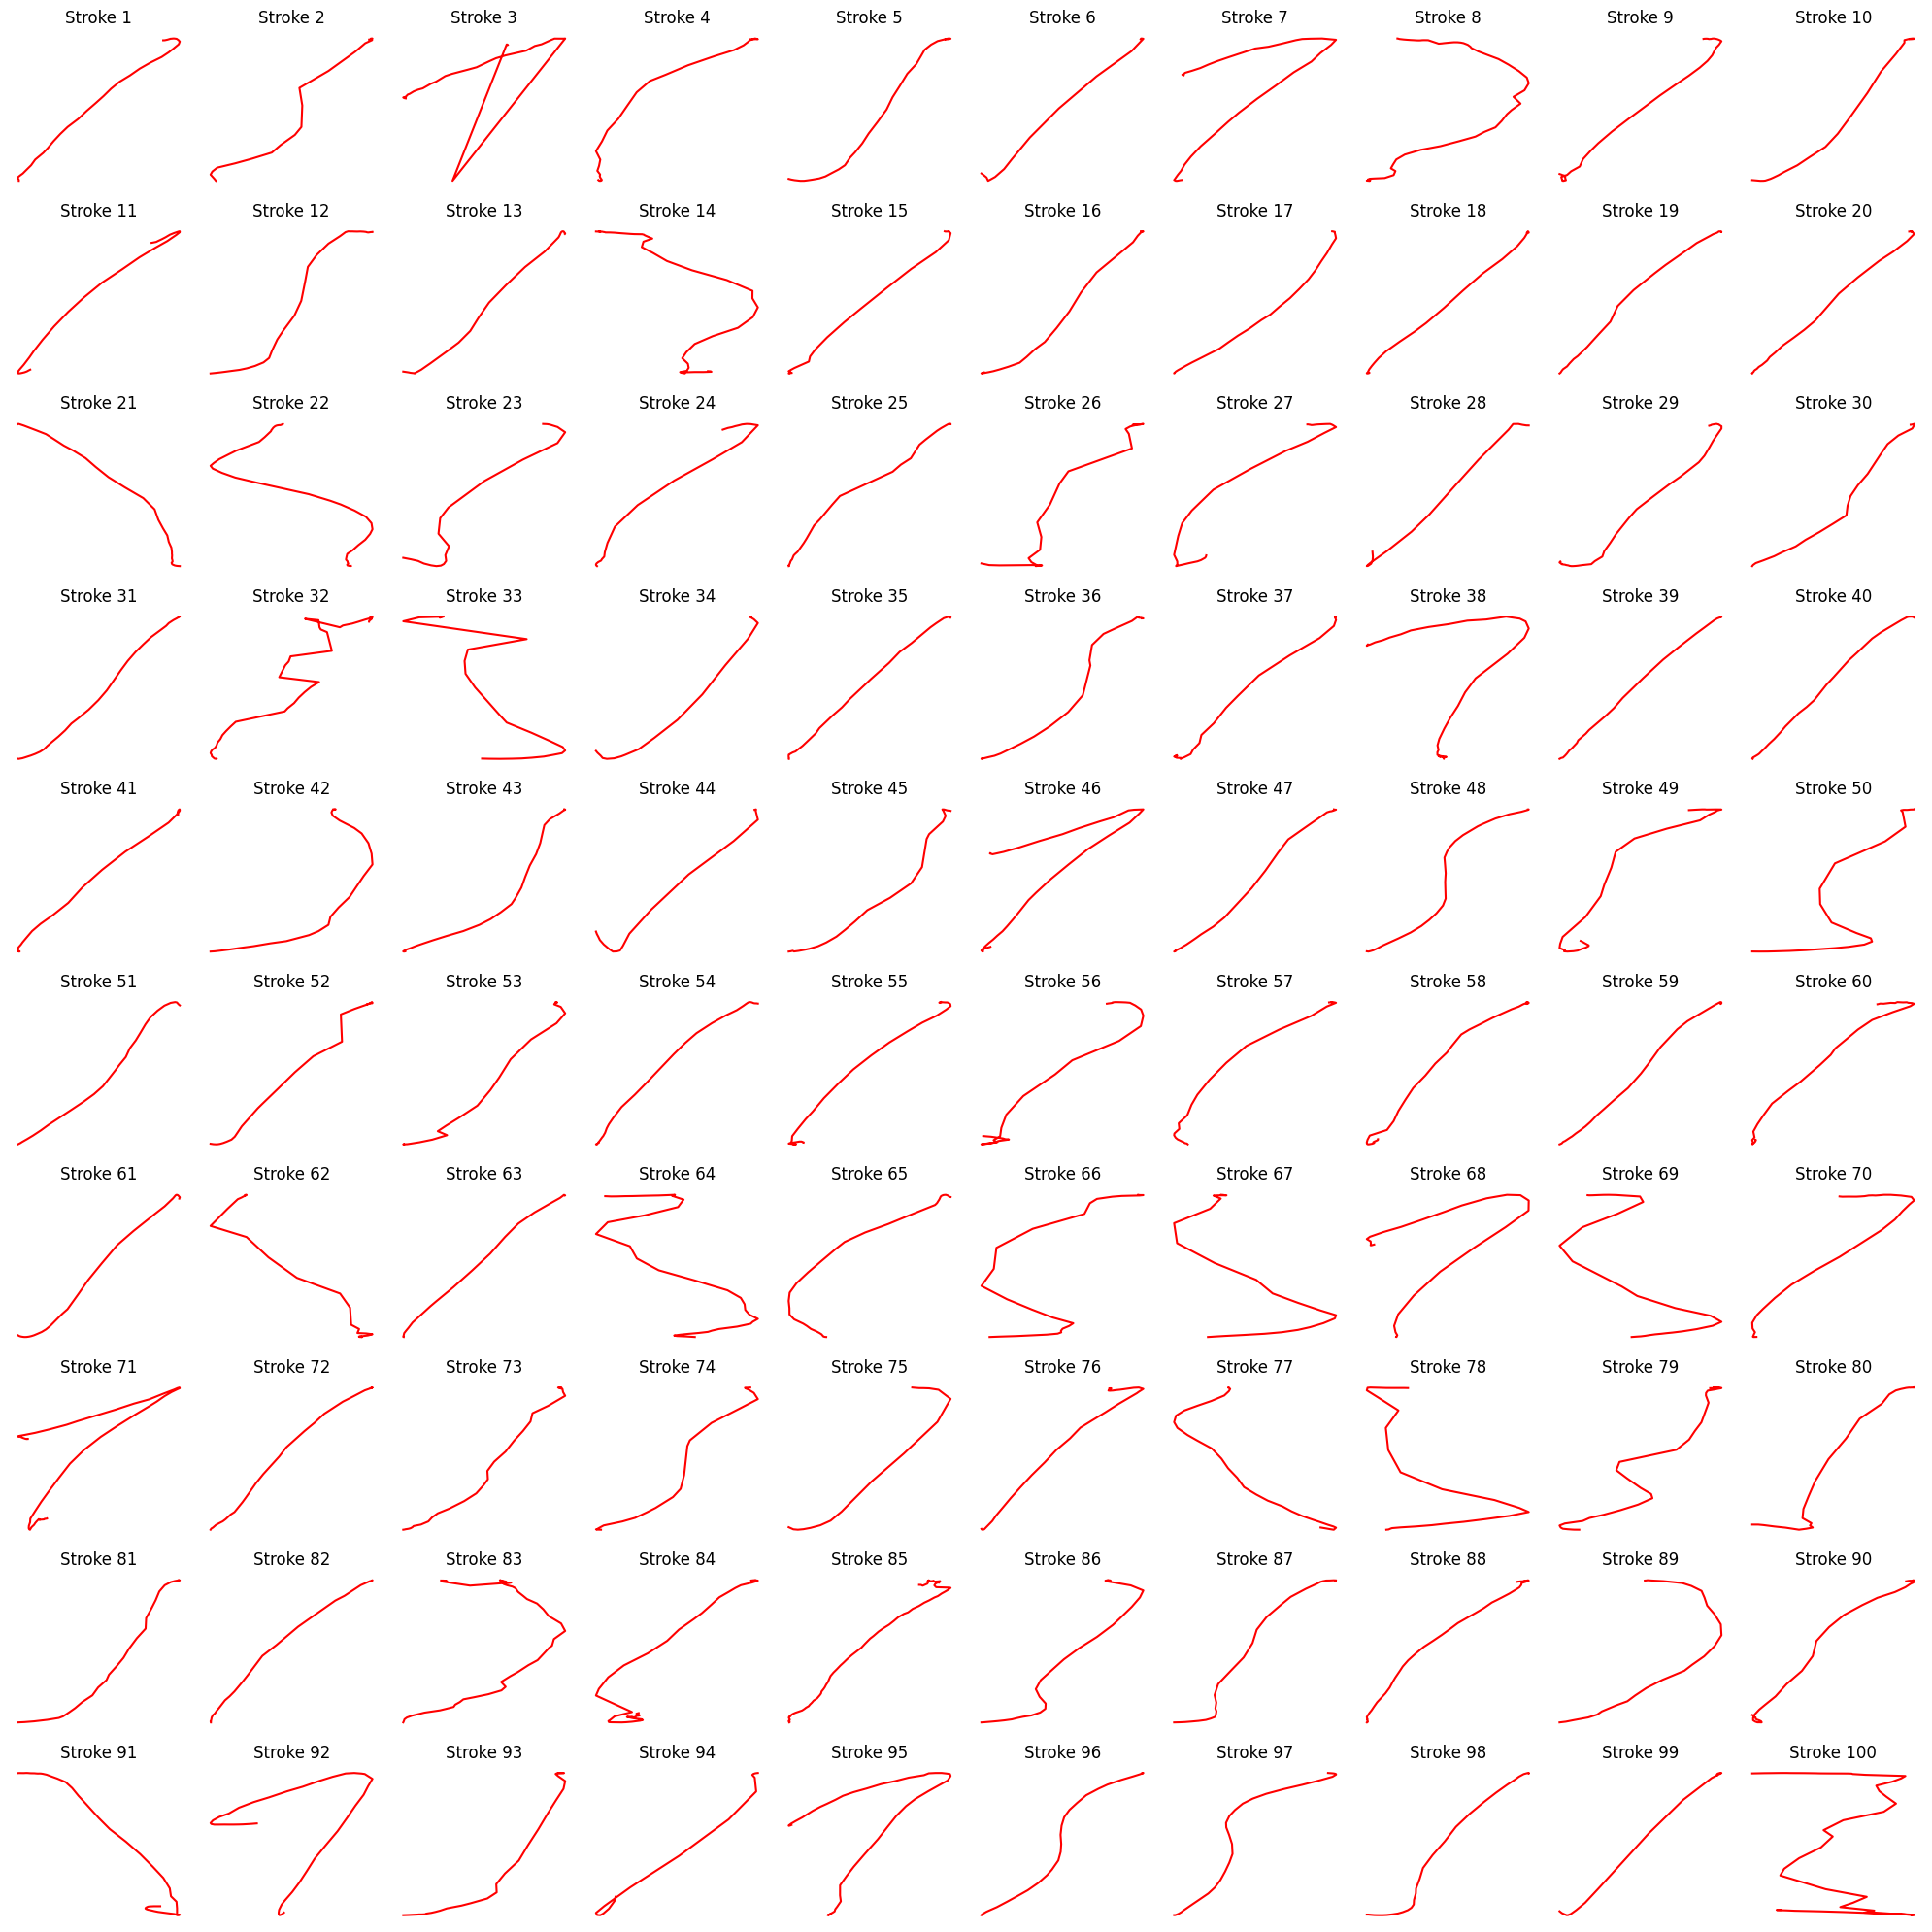

In [4]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

#
for r in range(100):
    file_name = f'stroke_1_{str(r+1).zfill(4)}.csv'
    to_load = os.path.join(folder_path, file_name)
    digit_data = pd.read_csv(to_load, header=None)

    row = r // 10
    col = r % 10
    ax[row, col].plot(digit_data[0], digit_data[1], c='r')
    ax[row, col].set_title(f'Stroke {r+1}')
    ax[row, col].axis('off')  # hide axes for better visualization

plt.tight_layout()
plt.show()

## Preprocessing

### Load each digit with its label

In [5]:
folder_path = 'digits_3d/training_data/'

X, y = [], []

for digit_label in range(10):        # iterate over digits 0-9
    for stroke_id in range(1, 101):  # 100 samples per digit
        file_name = f'stroke_{digit_label}_{str(stroke_id).zfill(4)}.csv'
        to_load = os.path.join(folder_path, file_name)

        if not os.path.exists(to_load):
            continue

        digit_data = pd.read_csv(to_load, header=None).values

        # normalize coordinates
        x_new = (digit_data[:, 0] - digit_data[:, 0].min()) / (digit_data[:, 0].max() - digit_data[:, 0].min())
        y_new = (digit_data[:, 1] - digit_data[:, 1].min()) / (digit_data[:, 1].max() - digit_data[:, 1].min())

        # generalize size to 28x28
        grid_size = 28
        x_final = (x_new * (grid_size - 1)).astype(int)
        y_final = (y_new * (grid_size - 1)).astype(int)

        # the image created by the line function need to be flipped on the y-axis by 90 degrees
        # that is because in the line function the y axis increases downwards because it uses matrix-bases
        # coordinate system as opposed to how normal coordinate systems work
        # create an empty matrix and connect the dots
        digit_conn_mat = np.zeros((grid_size, grid_size))
        for i in range(len(x_final) - 1):
            rr, cc = line(y_final[i], x_final[i], y_final[i + 1], x_final[i + 1])
            digit_conn_mat[rr, cc] = 1

        # flip vertically to correct orientation
        digit_conn_mat = digit_conn_mat[::-1]

        X.append(digit_conn_mat)
        y.append(digit_label)

# reshape for CNN
X = np.array(X).reshape(-1, 28, 28, 1)
y = np.array(y)

### Show image transformation

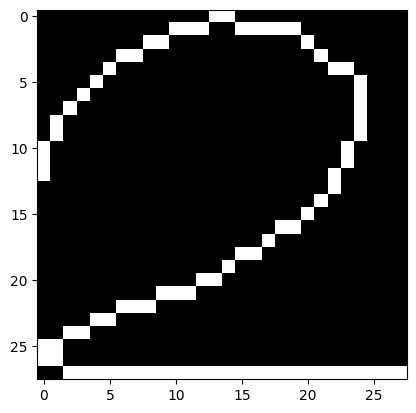

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(X[205], cmap='gray')
ax1.set_title('connected digit matrix')
plt.show()

## CNN

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # drop 25% of the neurons
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # drop 50% of the neurons
    Dense(10, activation='softmax')
])

### Compile

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Split data

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

## Train

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,                # stop after 4 epochs with no improvement
    restore_best_weights=True  # revert to the best weights
)

# data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
data_gen.fit(X_train)  # fit generator to the training data

model.fit(
    # data augmentation
    data_gen.flow(X_train, y_train, batch_size=12),

    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
67/67 [==============================] - 1s 9ms/step - loss: 1.9363 - accuracy: 0.3325 - val_loss: 0.8900 - val_accuracy: 0.8100
Epoch 2/20
67/67 [==============================] - 1s 11ms/step - loss: 1.2414 - accuracy: 0.5925 - val_loss: 0.5365 - val_accuracy: 0.8400
Epoch 3/20
67/67 [==============================] - 1s 12ms/step - loss: 1.0074 - accuracy: 0.6637 - val_loss: 0.2914 - val_accuracy: 0.9400
Epoch 4/20
67/67 [==============================] - 1s 12ms/step - loss: 0.9446 - accuracy: 0.7063 - val_loss: 0.2461 - val_accuracy: 0.9600
Epoch 5/20
67/67 [==============================] - 1s 13ms/step - loss: 0.7817 - accuracy: 0.7738 - val_loss: 0.2154 - val_accuracy: 0.9550
Epoch 6/20
67/67 [==============================] - 1s 10ms/step - loss: 0.6284 - accuracy: 0.8000 - val_loss: 0.1379 - val_accuracy: 0.9700
Epoch 7/20
67/67 [==============================] - 1s 13ms/step - loss: 0.5999 - accuracy: 0.7937 - val_loss: 0.1661 - val_accuracy: 0.9600
Epoch 8/20
67/

## Save model

In [11]:
model.save('digit_classifier.keras')

## Confusion Matrix

7/7 [==============================] - 0s 4ms/step


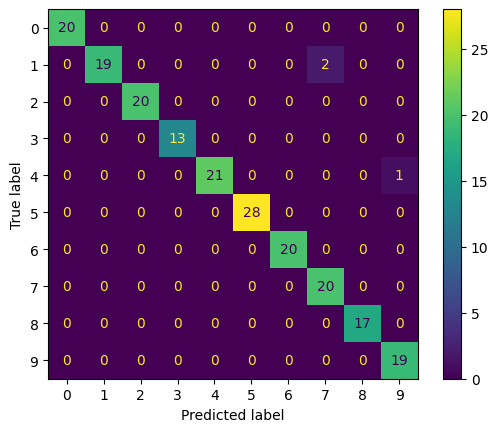

In [13]:
y_pred = model.predict(X_val).argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, labels=list(range(10))
)